In [1]:
#! /usr/bin/env python3


# import roslib
# import rospy
# from std_msgs.msg import String
# from sensor_msgs.msg import CompressedImage
# from sensor_msgs.msg import Image
import sys
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')




import time
import cv2
import torch
from numpy import random
import torch.backends.cudnn as cudnn
import numpy as np
from models.experimental import attempt_load
from utils.general import (
    check_img_size, non_max_suppression, apply_classifier, scale_coords,
    xyxy2xywh, plot_one_box, strip_optimizer, set_logging)
from utils.torch_utils import select_device, load_classifier, time_synchronized

from matplotlib import pyplot as plt

ros_image=0


def letterbox(img, new_shape=(640, 640), color=(114, 114, 114), auto=True, scaleFill=False, scaleup=True):
    # Resize image to a 32-pixel-multiple rectangle https://github.com/ultralytics/yolov3/issues/232
    shape = img.shape[:2]  # current shape [height, width]
    if isinstance(new_shape, int):
        new_shape = (new_shape, new_shape)

    # Scale ratio (new / old)
    r = min(new_shape[0] / shape[0], new_shape[1] / shape[1])
    if not scaleup:  # only scale down, do not scale up (for better test mAP)
        r = min(r, 1.0)

    # Compute padding
    ratio = r, r  # width, height ratios
    new_unpad = int(round(shape[1] * r)), int(round(shape[0] * r))
    dw, dh = new_shape[1] - new_unpad[0], new_shape[0] - new_unpad[1]  # wh padding
    if auto:  # minimum rectangle
        dw, dh = np.mod(dw, 32), np.mod(dh, 32)  # wh padding
    elif scaleFill:  # stretch
        dw, dh = 0.0, 0.0
        new_unpad = (new_shape[1], new_shape[0])
        ratio = new_shape[1] / shape[1], new_shape[0] / shape[0]  # width, height ratios

    dw /= 2  # divide padding into 2 sides
    dh /= 2

    if shape[::-1] != new_unpad:  # resize
        img = cv2.resize(img, new_unpad, interpolation=cv2.INTER_LINEAR)
    top, bottom = int(round(dh - 0.1)), int(round(dh + 0.1))
    left, right = int(round(dw - 0.1)), int(round(dw + 0.1))
    img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)  # add border
    return img, ratio, (dw, dh)
def loadimg(img):  # 接受opencv图片
    img_size=640
    cap=None
    path=None
    img0 = img
    img = letterbox(img0, new_shape=img_size)[0]
    img = img[:, :, ::-1].transpose(2, 0, 1)  # BGR to RGB, to 3x416x416
    img = np.ascontiguousarray(img)
    return path, img, img0, cap
# src=cv2.imread('biye.jpg')


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
with torch.no_grad():
    set_logging()
    device = ''
    device = select_device(device)
    half = device.type != 'cpu'  # half precision only supported on CUDA
    weights = 'yolov5s.pt'
    imgsz = 640
    model = attempt_load(weights, map_location=device)  # load FP32 model
    imgsz = check_img_size(imgsz, s=model.stride.max())  # check img_size
    if half:
        model.half()  # to FP16

Using CUDA device0 _CudaDeviceProperties(name='GeForce GT 1030', total_memory=1998MB)

Model Summary: 140 layers, 7.45958e+06 parameters, 0 gradients


Fusing layers... 


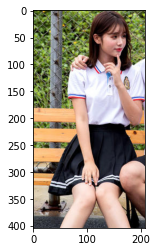

xyxy 55 100 262 504


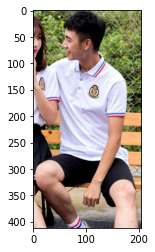

xyxy 211 96 416 508


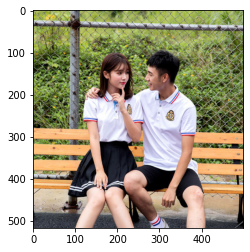

************
2-1 0.07023477554321289
3-2 0.1134190559387207
4-3 0.3119215965270996
total 0.4955754280090332


In [34]:
def get_one_box(x, img):
    a=int(x[1])
    b=int(x[3])
    c=int(x[0])
    d=int(x[2])
    crop=img[a:b,c:d]
    return crop

def detect(img):
    time1 = time.time()
    global ros_image
    cudnn.benchmark = True
    dataset = loadimg(img)
    # print(dataset[3])
    plt.imshow(dataset[2][:, :, ::-1])
    names = model.module.names if hasattr(model, 'module') else model.names
    #colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(names))]
    #colors=[[0,255,0]]
    augment = 'store_true'
    conf_thres = 0.3
    iou_thres = 0.45
    classes = (0,1,2,3,5,7)
    agnostic_nms = 'store_true'
    img = torch.zeros((1, 3, imgsz, imgsz), device=device)  # init img
    _ = model(img.half() if half else img) if device.type != 'cpu' else None  # run once
    path = dataset[0]
    img = dataset[1]
    im0s = dataset[2]
    vid_cap = dataset[3]
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0

    time2 = time.time()
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
    # Inference
    pred = model(img, augment=augment)[0]
    # Apply NMS
    pred = non_max_suppression(pred, conf_thres, iou_thres, classes=classes, agnostic=agnostic_nms)

    view_img = 0
    save_txt = 1
    save_conf = 'store_true'
    time3 = time.time()

    for i, det in enumerate(pred):  # detections per image
        p, s, im0 = path, '', im0s
        s += '%gx%g ' % img.shape[2:]  # print string
        gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
        if det is not None:
            #print(det)
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
            # Print results
            for c in det[:, -1].unique():
                n = (det[:, -1] == c).sum()  # detections per class
                s += '%g %ss, ' % (n, names[int(c)])  # add to string
                # Write results
            for *xyxy, conf, cls in reversed(det):
                if save_txt:  # Write to file
                    xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                    line = (cls, conf, *xywh) if save_conf else (cls, *xywh)  # label format
                if view_img:  # Add bbox to image
                    label = '%s %.2f' % (names[int(cls)], conf)
                    plot_one_box(xyxy, im0, label=label, color=[0,255,0], line_thickness=3)
                crop=get_one_box(xyxy,im0)
                crop=crop[...,::-1]
                plt.imshow(crop)
                plt.show()
                print("xyxy",int(xyxy[0].cpu().numpy()),int(xyxy[1].cpu().numpy()),
                      int(xyxy[2].cpu().numpy()),int(xyxy[3].cpu().numpy()))
    if 1:
        rgb = im0[...,::-1]
        plt.imshow(rgb)
        plt.show()
    time4 = time.time()
    print('************')
    print('2-1', time2 - time1)
    print('3-2', time3 - time2)
    print('4-3', time4 - time3)
    print('total',time4-time1)

    
img=cv2.imread('2.jpg',-1)
detect(img)